# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Good luck & have fun! :)

In [43]:
import math
import os
import random
import sys


import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as tt
from PIL import Image
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
import torchvision
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm
from torchsummary import summary

In [2]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(123456)

In [7]:
# !wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

zsh:1: no matches found: https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1


## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True)

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели.
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать:

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали.
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [4]:
batch_size = 32
image_size = 64

### Подготовка данных

In [5]:
train_transform = tt.Compose([
    tt.ToTensor(),
    # tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tt.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_transform = tt.Compose([
    tt.ToTensor(),
    # tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tt.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# path_train = "/content/dataset/dataset/train"
# path_test = "/content/dataset/dataset/val"
path_train = "../../data/dataset/dataset/train/"
path_test = "../../data/dataset/dataset/val/"

train_dataset = ImageFolder(path_train, transform=train_transform)
test_dataset = ImageFolder(path_test, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


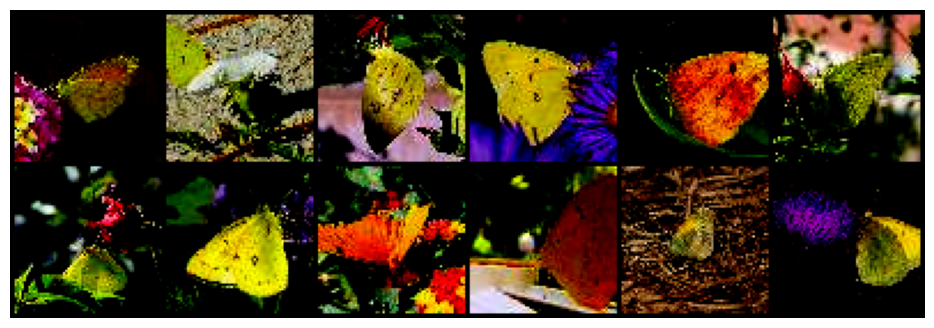

In [7]:
def show_images(nrow=12, figsize=(15, 4)):
    images_tensors = []
    for i in range(nrow):
        images_tensors.append(train_dataset[i][0])
    grid = torchvision.utils.make_grid(images_tensors, nrow=6, padding=2)
    grid_np = grid.permute(1, 2, 0).numpy()
    plt.figure(figsize=figsize)
    plt.imshow(grid_np)
    plt.axis('off')
    plt.show()

show_images()

## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [32]:
class YourNet(nn.Module):
    def __init__(self):
        super(YourNet, self).__init__()
        self.conv_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.norm_1 = nn.BatchNorm2d(64)
        self.conv_2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.norm_2 = nn.BatchNorm2d(128)
        self.conv_3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.norm_3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_1 = nn.Linear(256*8*8, 512)
        self.fc_2 = nn.Linear(512, 200)

    def forward(self, x):
        x = torch.relu(self.norm_1(self.conv_1(x)))
        x = self.pool(x)
        x = torch.relu(self.norm_2(self.conv_2(x)))
        x = self.pool(x)
        x = torch.relu(self.norm_3(self.conv_3(x)))
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = torch.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
        

In [56]:
class LitYourNet(pl.LightningModule):
    def __init__(self, lr=1e-1):
        super().__init__()
        self.lr = lr
        self.model = YourNet()

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch_train):
        x, y = batch_train
        x = self.model(x)
        loss = nn.CrossEntropyLoss()(x, y)
        self.log("train_loss", loss.item(), on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, val_batch):
        x, y = val_batch
        x = self.model(x)
        loss = nn.CrossEntropyLoss()(x, y)
        self.log("val_loss", loss.item(), on_epoch=True, prog_bar=True)

In [59]:
model = LitYourNet()
trainer = pl.Trainer(max_epochs=10)
tuner = pl.tuner.Tuner(trainer)
lr_finder = tuner.lr_find(model, train_loader, max_lr=max_lr)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

TypeError: on_train_epoch_end() missing 1 required positional argument: 'outputs'

In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
new_lr = lr_finder.suggestion()
model.lr = new_lr

In [ ]:
trainer.fit(model, train_loader, test_loader)

In [41]:
for epoch in range(trainer.current_epoch + 1):
    train_loss = trainer.callback_metrics.get('train_loss_epoch', None)
    val_loss = trainer.callback_metrics.get('val_loss_epoch', None)
    print(f'Epoch {epoch}: Train Loss - {train_loss}, Validation Loss - {val_loss}')

Epoch 0: Train Loss - 5.314688205718994, Validation Loss - None
Epoch 1: Train Loss - 5.314688205718994, Validation Loss - None
Epoch 2: Train Loss - 5.314688205718994, Validation Loss - None
Epoch 3: Train Loss - 5.314688205718994, Validation Loss - None


In [ ]:
# from torchvision.models import resnet18
# model = resnet18(weights=None)
# model.fc = nn.Linear(512, 200)
# model.to(device)

In [19]:
summary(model, (3, image_size, image_size))
None

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─MaxPool2d: 1-3                         [-1, 64, 32, 32]          --
├─Conv2d: 1-4                            [-1, 128, 32, 32]         73,856
├─BatchNorm2d: 1-5                       [-1, 128, 32, 32]         256
├─MaxPool2d: 1-6                         [-1, 128, 16, 16]         --
├─Conv2d: 1-7                            [-1, 256, 16, 16]         295,168
├─BatchNorm2d: 1-8                       [-1, 256, 16, 16]         512
├─MaxPool2d: 1-9                         [-1, 256, 8, 8]           --
├─Linear: 1-10                           [-1, 512]                 8,389,120
├─Linear: 1-11                           [-1, 512]                 262,656
├─Linear: 1-12                           [-1, 200]                 102,600
Total params: 9,126,088
Trainable params: 9,126,088
N

In [125]:
def fit(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler):
    hist_train_loss = []
    hist_test_loss = []
    hist_train_accuracy = []
    hist_test_accuracy = []

    for epoch in tqdm(range(epochs)):
        avg_loss = 0
        avg_accuracy = 0
        model.train()
        for xb, yb in tqdm(train_loader, desc="-----"):
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            loss = criterion(output, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            logit = torch.softmax(output, dim=1)
            y_pred = torch.argmax(logit, dim=1)
            avg_loss += loss.item()
            avg_accuracy += accuracy(y_pred, yb, task="multiclass", num_classes=200).item()
        hist_train_loss.append(avg_loss / len(train_loader))
        hist_train_accuracy.append(avg_accuracy / len(train_loader))
        scheduler.step()

        model.eval()
        with torch.no_grad():
            avg_loss = 0
            avg_accuracy = 0
            for xb, yb in tqdm(test_loader, desc="-----"):
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                loss = criterion(output, yb)
                logit = torch.softmax(output, dim=1)
                y_pred = torch.argmax(logit, dim=1)
                avg_loss += loss.item()
                avg_accuracy += accuracy(y_pred, yb, task="multiclass", num_classes=200).item()
            hist_test_loss.append(avg_loss / len(test_loader))
            hist_test_accuracy.append(avg_accuracy / len(test_loader))

        train_loss = round(hist_train_loss[-1], 5)
        test_loss = round(hist_test_loss[-1], 5)
        train_accuracy = round(hist_train_accuracy[-1], 5)
        test_accuracy = round(hist_test_accuracy[-1], 5)
        last_lr = scheduler.get_last_lr()[0]

        print(f'Epoch: {epoch+1} \n train_loss: {train_loss},  test_loss: {test_loss}, \n train_accuracy: {train_accuracy},  test_accuracy: {test_accuracy} \n last_lr: {last_lr}')

    return hist_train_loss, hist_test_loss, hist_train_accuracy, hist_test_accuracy

In [126]:
epochs = 20
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.5)

hist = fit(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 
 train_loss: 5.01755,  test_loss: 4.74839, 
 train_accuracy: 0.02295,  test_accuracy: 0.04812 
 last_lr: 0.01


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 
 train_loss: 4.29146,  test_loss: 3.93724, 
 train_accuracy: 0.09094,  test_accuracy: 0.13678 
 last_lr: 0.01


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 
 train_loss: 3.81021,  test_loss: 3.66603, 
 train_accuracy: 0.15613,  test_accuracy: 0.17382 
 last_lr: 0.01


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 
 train_loss: 3.54722,  test_loss: 3.44956, 
 train_accuracy: 0.19741,  test_accuracy: 0.21086 
 last_lr: 0.01


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 
 train_loss: 3.32049,  test_loss: 3.33009, 
 train_accuracy: 0.2362,  test_accuracy: 0.23433 
 last_lr: 0.01


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6 
 train_loss: 3.10412,  test_loss: 3.2422, 
 train_accuracy: 0.27507,  test_accuracy: 0.25968 
 last_lr: 0.01


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7 
 train_loss: 2.89538,  test_loss: 3.17205, 
 train_accuracy: 0.31101,  test_accuracy: 0.27506 
 last_lr: 0.01


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8 
 train_loss: 2.66765,  test_loss: 3.21758, 
 train_accuracy: 0.35147,  test_accuracy: 0.27696 
 last_lr: 0.01


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9 
 train_loss: 2.43062,  test_loss: 3.31459, 
 train_accuracy: 0.39632,  test_accuracy: 0.27845 
 last_lr: 0.01


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 10 
 train_loss: 2.18196,  test_loss: 3.41487, 
 train_accuracy: 0.44321,  test_accuracy: 0.26977 
 last_lr: 0.005


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 11 
 train_loss: 1.58998,  test_loss: 3.76873, 
 train_accuracy: 0.5701,  test_accuracy: 0.28135 
 last_lr: 0.005


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 12 
 train_loss: 1.29703,  test_loss: 4.19941, 
 train_accuracy: 0.63401,  test_accuracy: 0.27196 
 last_lr: 0.005


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 13 
 train_loss: 1.07795,  test_loss: 4.58821, 
 train_accuracy: 0.68819,  test_accuracy: 0.26428 
 last_lr: 0.005


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 14 
 train_loss: 0.90432,  test_loss: 4.96742, 
 train_accuracy: 0.7304,  test_accuracy: 0.25769 
 last_lr: 0.005


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 15 
 train_loss: 0.76343,  test_loss: 5.33682, 
 train_accuracy: 0.76663,  test_accuracy: 0.25639 
 last_lr: 0.0025


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 16 
 train_loss: 0.46941,  test_loss: 6.16341, 
 train_accuracy: 0.85473,  test_accuracy: 0.25439 
 last_lr: 0.0025


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 17 
 train_loss: 0.36814,  test_loss: 6.67517, 
 train_accuracy: 0.88583,  test_accuracy: 0.2486 
 last_lr: 0.0025


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 18 
 train_loss: 0.31246,  test_loss: 7.04149, 
 train_accuracy: 0.90057,  test_accuracy: 0.2515 
 last_lr: 0.0025


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 19 
 train_loss: 0.26978,  test_loss: 7.4254, 
 train_accuracy: 0.91455,  test_accuracy: 0.2527 
 last_lr: 0.0025


-----:   0%|          | 0/3125 [00:00<?, ?it/s]

-----:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 20 
 train_loss: 0.24808,  test_loss: 7.73075, 
 train_accuracy: 0.9196,  test_accuracy: 0.2504 
 last_lr: 0.0025


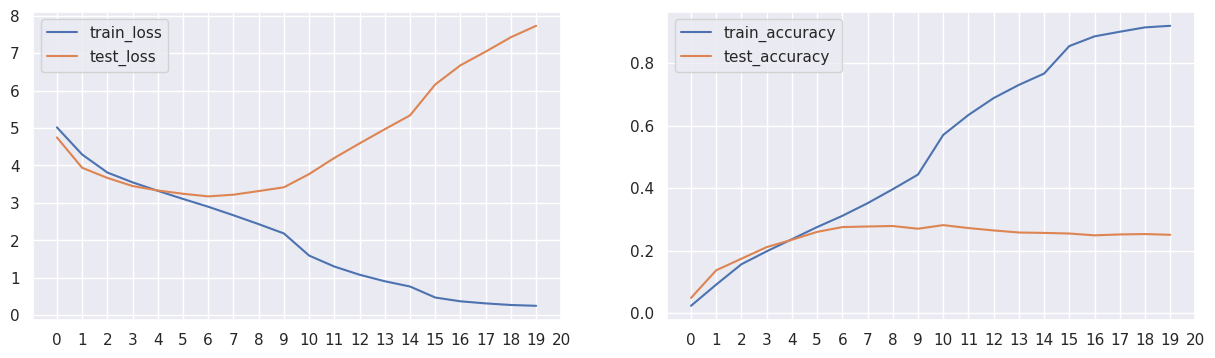

In [127]:
import seaborn as sns
sns.set(style="darkgrid")
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

x = range(epochs)
sns.lineplot(x=x, y=hist[0], label="train_loss", ax=ax[0])
sns.lineplot(x=x, y=hist[1], label="test_loss", ax=ax[0])

sns.lineplot(x=x, y=hist[2], label="train_accuracy", ax=ax[1])
sns.lineplot(x=x, y=hist[3], label="test_accuracy", ax=ax[1])

ax[0].set_xticks(range(epochs+1))
ax[1].set_xticks(range(epochs+1))
plt.legend()
plt.show()

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        # YOUR CODE HERE
        pass

    def forward(self, x):
        # YOUR CODE HERE
        pass

    def configure_optimizers(self):
        # YOUR CODE HERE
        pass

    def training_step(self, train_batch, batch_idx):
        # YOUR CODE HERE
        pass

    def validation_step(self, val_batch, batch_idx):
        # YOUR CODE HERE
        pass

In [ ]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
device =  # YOUR CODE HERE

model = YourNet().to() # YOUR CODE HERE
module = YourModule() # YOUR CODE HERE

In [ ]:
trainer = pl.Trainer(logger=wandb_logger)  # YOUR CODE HERE
trainer.fit()  # YOUR CODE HERE